In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
  
# append the path of the parent directory
sys.path.append("..")

import time
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from models import UNet
import utils

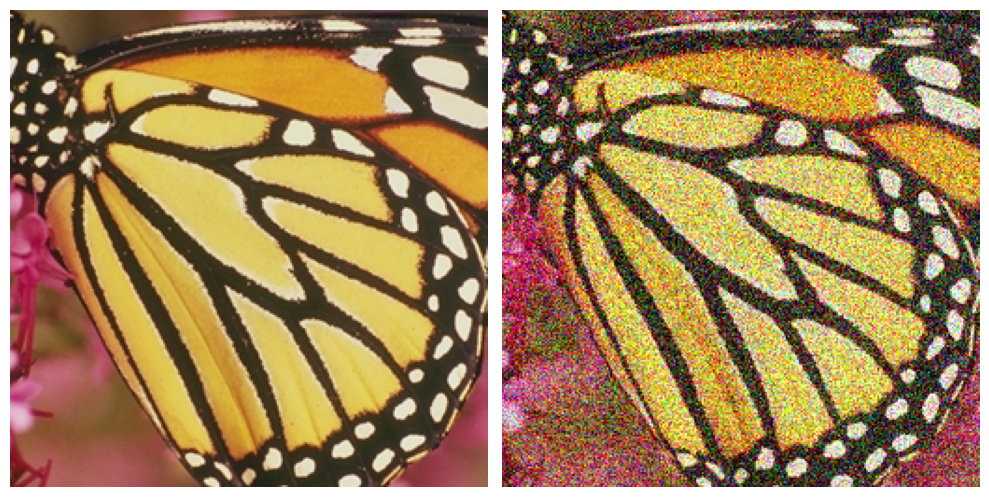

In [6]:
x = utils.load_image('../data/set5/butterfly.png')
# x = utils.load_celeba(1)
x_hat = torch.stack([utils.get_noisy_image(img, 0.2) for img in x])
utils.plot_row([x, x_hat])

In [7]:
input_channels = 3
deep_channels = [8, 16, 32, 64, 128]
skip_channels = [0, 0, 0, 4, 4]

lr = 0.01

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = UNet(input_channels, deep_channels, skip_channels)
net.to(device)

optimizer = optim.Adam(net.parameters(), lr)

mse = nn.MSELoss()
psnr = PeakSignalNoiseRatio().to(device)

x = x.to(device)
x_hat = x_hat.to(device)

input_shape = [input_channels if i == 1 else s for i, s in enumerate(x_hat.size())]
z = torch.rand(input_shape, device=device) * 0.1

In [9]:
def tv_norm(x):
    diff_v = torch.abs(x[:, :-1, :] - x[:, 1:, :])
    diff_h = torch.abs(x[:, :, :-1] - x[:, :, 1:])

    tv_norm = torch.sum(diff_v) + torch.sum(diff_h)

    normalized = tv_norm / x.sum()

    return normalized.item()

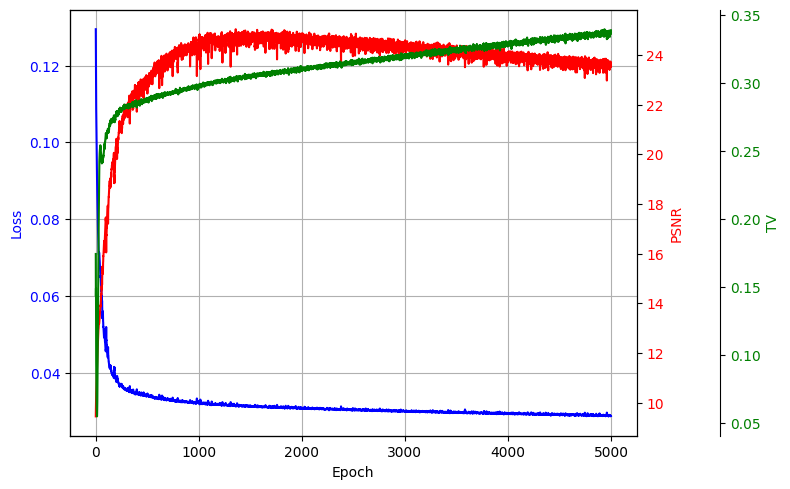

----------
Finished training in 00:03:03



In [10]:
print(f'Training on {device}')
start = time.time()

losses = []
psnrs = []
tvs = []

t = 0
y0 = None
while t < 5000:
  net.train()
  optimizer.zero_grad()

  out = net(z)
  loss = mse(out, x_hat)
  loss.backward()
  optimizer.step()

  net.eval()

  if t == 0:
    y0 = out.detach().cpu()

  losses.append(loss.item())
  psnrs.append(psnr(out, x).item())
  tvs.append(tv_norm(out))

  if t % 100 == 99:
    clear_output(wait=True)
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.grid()

    ax1.plot(losses, 'b-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(psnrs, 'r-')
    ax2.set_ylabel('PSNR', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(tvs, 'g-')
    ax3.set_ylabel('TV', color='g')
    ax3.tick_params(axis='y', labelcolor='g')

    # ax1.axvline(x=t_opt, color='purple', linestyle='--', label=f'Stopping Point')

    fig.tight_layout()
    plt.show()

  t += 1

duration = time.time() - start
print('----------')
print(f'Finished training in {time.strftime('%H:%M:%S', time.gmtime(duration))}\n')

In [ ]:
utils.plot_row([x, y0, x_hat])

NameError: name 'utils' is not defined